In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentinel-2-msi-wildfire-data-for-research/dataset/chop_no_firee/tile_2_1_7.tif
/kaggle/input/sentinel-2-msi-wildfire-data-for-research/dataset/chop_no_firee/tile_3_1_3.tif
/kaggle/input/sentinel-2-msi-wildfire-data-for-research/dataset/chop_no_firee/tile_3_1_1.tif
/kaggle/input/sentinel-2-msi-wildfire-data-for-research/dataset/chop_no_firee/tile_2_1_2.tif
/kaggle/input/sentinel-2-msi-wildfire-data-for-research/dataset/chop_no_firee/tile_2_0_1.tif
/kaggle/input/sentinel-2-msi-wildfire-data-for-research/dataset/chop_no_firee/tile_3_0_1.tif
/kaggle/input/sentinel-2-msi-wildfire-data-for-research/dataset/chop_no_firee/tile_2_0_2.tif
/kaggle/input/sentinel-2-msi-wildfire-data-for-research/dataset/chop_no_firee/tile_0_0_2.tif
/kaggle/input/sentinel-2-msi-wildfire-data-for-research/dataset/chop_no_firee/tile_1_1_3.tif
/kaggle/input/sentinel-2-msi-wildfire-data-for-research/dataset/chop_no_firee/tile_0_0_1.tif
/kaggle/input/sentinel-2-msi-wildfire-data-for-research/dataset/chop_n

In [2]:
!pip install rasterio --quiet
!pip install albumentations --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 74.6 MB/s eta 0:00:00


In [3]:
import os
import rasterio
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [4]:
def load_geotiff_image(path):
    with rasterio.open(path) as src:
        img = src.read()
        return img.astype(np.float32)

In [5]:
sample_path = "/kaggle/input/sentinel-2-msi-wildfire-data-for-research/dataset/chop_fire/tile_0_1_1.tif"
image = load_geotiff_image(sample_path)
print(image.shape)

(6, 512, 512)


In [6]:
class WildfireDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.fire_dir = os.path.join(root_dir, 'chop_fire')
        self.no_fire_dir = os.path.join(root_dir, 'chop_no_firee')  
        self.fire_images = [os.path.join(self.fire_dir, f) for f in os.listdir(self.fire_dir)]
        self.no_fire_images = [os.path.join(self.no_fire_dir, f) for f in os.listdir(self.no_fire_dir)]
        self.images = self.fire_images + self.no_fire_images
        self.labels = [1] * len(self.fire_images) + [0] * len(self.no_fire_images)
        self.transform = transform

    def __len__(self):
        return len(self.images) 

    def __getitem__(self, idx):
        img = load_geotiff_image(self.images[idx])
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


In [7]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x)),
    transforms.Lambda(lambda x: x / 10000.0),
])

dataset = WildfireDataset('/kaggle/input/sentinel-2-msi-wildfire-data-for-research/dataset', transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class FireClassifier(nn.Module):
    def __init__(self):
        super(FireClassifier, self).__init__()
        self.conv1 = nn.Conv2d(6, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        
        self.flatten_dim = None 

        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        
       
        if self.flatten_dim is None:
            self.flatten_dim = x.view(x.size(0), -1).shape[1]
            self.fc1 = nn.Linear(self.flatten_dim, 128).to(x.device)
        
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FireClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):  # Start with 5 epochs
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")


Epoch 1, Loss: 0.6931053638458252
Epoch 2, Loss: 0.6930331468582154
Epoch 3, Loss: 0.6928056418895722
Epoch 4, Loss: 0.6926457405090332
Epoch 5, Loss: 0.6926219999790192


In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {acc}")
print("confusion Matrix:")
print(cm)

Accuracy: 0.5512820512820513
confusion Matrix:
[[43  0]
 [35  0]]


In [11]:
torch.save(model.state_dict(), 'wildfire_model.pth')

In [12]:
print("Fire:", sum(dataset.labels))
print("No Fire:", len(dataset.labels) - sum(dataset.labels))


Fire: 35
No Fire: 43


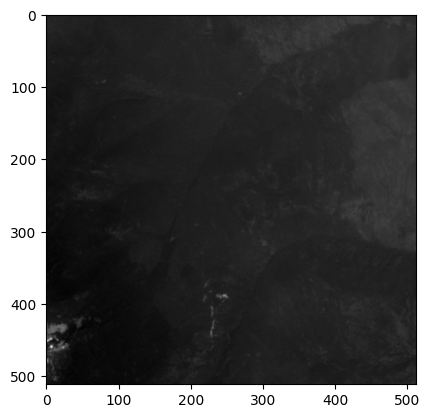

In [13]:
img = load_geotiff_image(sample_path)
plt.imshow(img[2], cmap='gray') 


In [14]:
fire = sum(dataset.labels)
no_fire = len(dataset.labels) - fire
total = fire + no_fire


weight = torch.tensor([no_fire / total, fire / total], dtype=torch.float32).to(device)


criterion = nn.CrossEntropyLoss(weight=weight)



In [15]:
for epoch in range(5): 
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # uses weighted loss now
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")


Epoch 1, Loss: 0.6918448448181153
Epoch 2, Loss: 0.6914028227329254
Epoch 3, Loss: 0.6911301434040069
Epoch 4, Loss: 0.6908050060272217
Epoch 5, Loss: 0.6904090166091919


In [16]:
print(f"Accuracy: {acc}")
print("Confusion Matrix:")
print(cm)


Accuracy: 0.5512820512820513
Confusion Matrix:
[[43  0]
 [35  0]]


In [17]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=['No Fire', 'Fire']))


              precision    recall  f1-score   support

     No Fire       0.55      1.00      0.71        43
        Fire       0.00      0.00      0.00        35

    accuracy                           0.55        78
   macro avg       0.28      0.50      0.36        78
weighted avg       0.30      0.55      0.39        78



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        handle_fw = self.target_layer.register_forward_hook(forward_hook)
        handle_bw = self.target_layer.register_backward_hook(backward_hook)
        self.hook_handles.extend([handle_fw, handle_bw])

    def generate(self, input_tensor, target_class=None):
        self.model.eval()
        output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        loss = output[0, target_class]
        self.model.zero_grad()
        loss.backward()

        pooled_gradients = self.gradients.mean(dim=[0, 2, 3])
        weighted_activations = self.activations[0] * pooled_gradients[:, None, None]
        cam = weighted_activations.sum(dim=0).cpu().numpy()

        cam = np.maximum(cam, 0)
        cam = cam / cam.max()
        return cam


In [19]:

sample_path = dataset.images[10]  # or any index
image = load_geotiff_image(sample_path)
input_tensor = transform(image).unsqueeze(0).to(device)


In [20]:

target_layer = model.conv2


gradcam = GradCAM(model, target_layer)


cam = gradcam.generate(input_tensor)


from skimage.transform import resize
cam_resized = resize(cam, (512, 512))


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


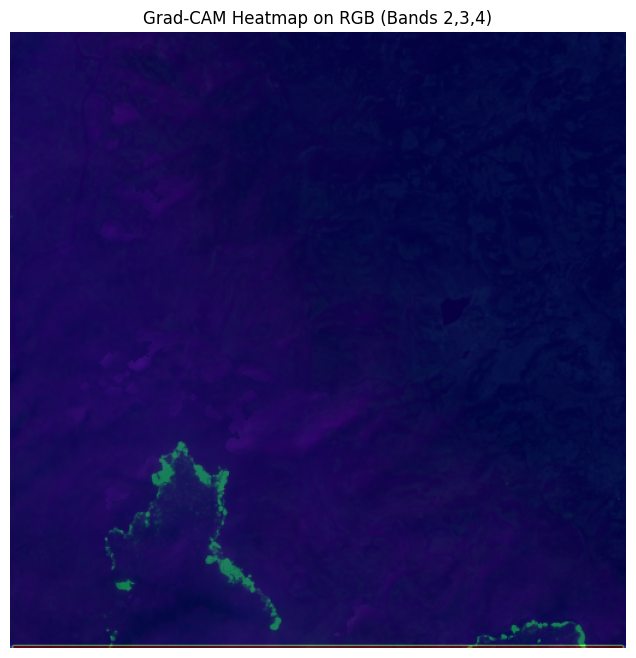

In [21]:
import matplotlib.pyplot as plt


img_rgb = image[[1, 2, 3], :, :].transpose(1, 2, 0)  # (H,W,C)


img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())


plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.imshow(cam_resized, cmap='jet', alpha=0.5)  # Heatmap overlay
plt.title("Grad-CAM Heatmap on RGB (Bands 2,3,4)")
plt.axis('off')
plt.show()


In [22]:
cam = gradcam.generate(input_tensor, target_class=1)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Text(0.5, 1.0, 'Grad-CAM Heatmap on (NIR, Red, SWIR)')

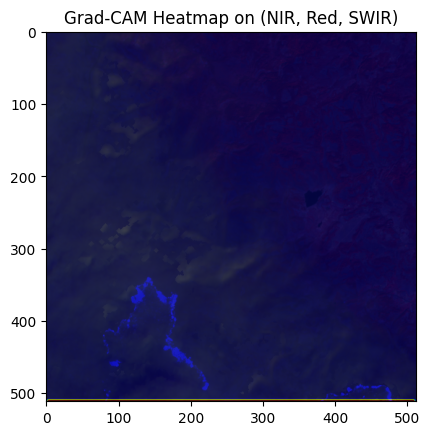

In [23]:
img_fire = image[[4, 3, 5], :, :].transpose(1, 2, 0)  # Bands 8,4,12 = NIR, Red, SWIR
img_fire = (img_fire - img_fire.min()) / (img_fire.max() - img_fire.min())

plt.imshow(img_fire)
plt.imshow(cam_resized, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Heatmap on (NIR, Red, SWIR)")
